# NOTES

- Applying `normalize_subset` to all records that contain `"(?i)microsoft|msft"` - i.e., a group of records that almost certainly all belong to MSFT - the algorithm works. This implies that the issue is indeed with the subgraph creation. I.e., the `"microsoft"` subgraph is being linked to other companies. Most likely, this is because there are 1 or 2 records with, e.g., `{"issuer_name": "microsoft", "cusip": apple's cusip}`. We 

# Main

In [2]:
import polars as pl
from record_consolidation.graphs import (
    unconsolidated_df_to_graph,
    extract_connected_subgraphs,
)
import networkx as nx

# import plotly.express as px
# import plotly.graph_objects as go

In [5]:
# votes: pl.DataFrame = access_db_table("raw_output", "votes")
votes: pl.DataFrame = pl.read_parquet("raw_votes.parquet")
COMPANY_COLS = pl.col(["issuer_name", "cusip", "isin", "figi"])
MEETING_COLS = pl.col(["issuer_name", "meeting_date", "cusip", "isin", "figi"])

In [6]:
subgraphs = list(
    extract_connected_subgraphs(
        unconsolidated_df_to_graph(votes.select(COMPANY_COLS), weight_edges=True)
    )
)

In [7]:
from typing import Iterable
from warnings import warn


def extract_specific_name_subgraph(
    connected_subgs: Iterable[nx.Graph], name: str
) -> nx.Graph:
    collected: list[nx.Graph] = []
    for subg in connected_subgs:
        for n in subg.nodes.data():
            if name.lower() in (n[0]).lower():
                collected.append(subg)
    collected = set(collected)
    if len(collected) == 0:
        raise ValueError(f"Could not find {name=} in connected_subgs.")
    if len(collected) > 1:
        alert_str = f"{len(collected)} subgraphs have {name=}.\n{[len(subg.nodes) for subg in collected]=}"
        warn(alert_str)
        return max(collected, key=lambda g: len(g.nodes))

        # raise ValueError(alert_str)
    return tuple(collected)[0]

In [8]:
msft_subgraph = extract_specific_name_subgraph(subgraphs, "microsoft")
mcds_subgraph = extract_specific_name_subgraph(subgraphs, "mcdonald")
jpm_subgraph = extract_specific_name_subgraph(subgraphs, "jpmorgan")

/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_35657/942150125.py:18: UserWarning: 3 subgraphs have name='mcdonald'.
[len(subg.nodes) for subg in collected]=[2, 54, 1]
  warn(alert_str)
/var/folders/z7/gyrmrn1s10zf6k523_6hg_br0000gn/T/ipykernel_35657/942150125.py:18: UserWarning: 2 subgraphs have name='jpmorgan'.
[len(subg.nodes) for subg in collected]=[1, 61]
  warn(alert_str)


In [9]:
jpm_subgraph

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def draw_graph(G: nx.Graph, size: int = 12):
    # Use spring_layout with adjusted parameters
    pos = nx.spring_layout(G, k=0.25, iterations=100, seed=42)
    edge_weights = [G[u][v]["count"] for u, v in G.edges()]
    # Draw the graph with the new layout
    plt.figure(figsize=(size, size))
    nx.draw_networkx(
        G,
        pos=pos,
        arrows=True,
        node_size=[np.sqrt(x[1]["count"]) * 50 for x in G.nodes.data()],
        width=np.sqrt(edge_weights),
        with_labels=True,
        font_size=6,
    )
    plt.show()


draw_graph(msft_subgraph, size=12)
draw_graph(mcds_subgraph, size=5)

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

In [13]:
from typing import Callable


def has_high_max_betweenness(G: nx.Graph, threshold: float = 0.06) -> bool:
    # TODO: this decision rule could be improved for the case of JPMorgan
    # Surely there's something that can measure this perfectly
    betweennesses: dict[tuple, float] = nx.edge_betweenness_centrality(
        G, weight="count", normalized=True
    )
    max_betweenness: float = max(betweennesses.values())
    print(f"{max_betweenness=}\n{threshold=}")
    return max_betweenness >= threshold


def split_subgraph_where_necessary(
    G: nx.Graph,
    should_cut: Callable[[nx.Graph], bool] = has_high_max_betweenness,
    max_cuts: int = 3,
    verbose: bool = False,
) -> nx.Graph:
    # TODO: save cut_points when possible
    i = 0
    if verbose:
        draw_graph(G, size=10)
    while should_cut(G):
        if verbose:
            print(f"Iteration: {i}")

        cut_points = tuple(nx.articulation_points(G))
        if len(cut_points) == 0 or i > max_cuts:
            break

        # TODO(?): assess betweenness_centrality of cut_points; only cut if > some X

        data = G.nodes.data()
        cut_point_counts: dict[str, int] = {
            name: data[name]["count"] for name in cut_points
        }
        to_cut: str = min(cut_point_counts, key=cut_point_counts.get)
        G.remove_node(to_cut)

        cut_points = tuple(nx.articulation_points(G))
        if verbose:
            draw_graph(G, size=10)
        i += 1
    return G

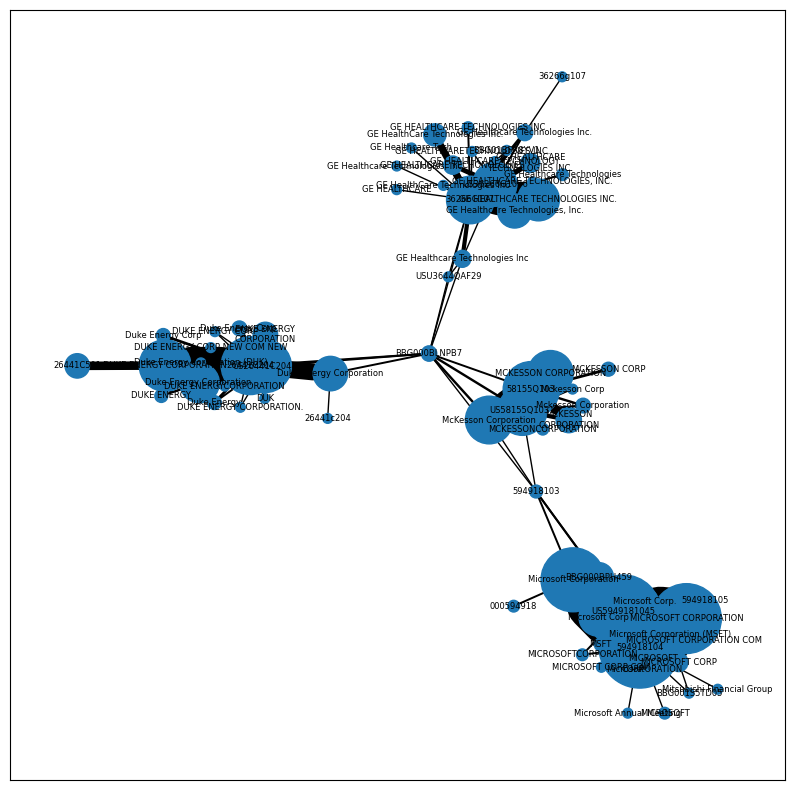

max_betweenness=0.45191146881287725
threshold=0.06
Iteration: 0


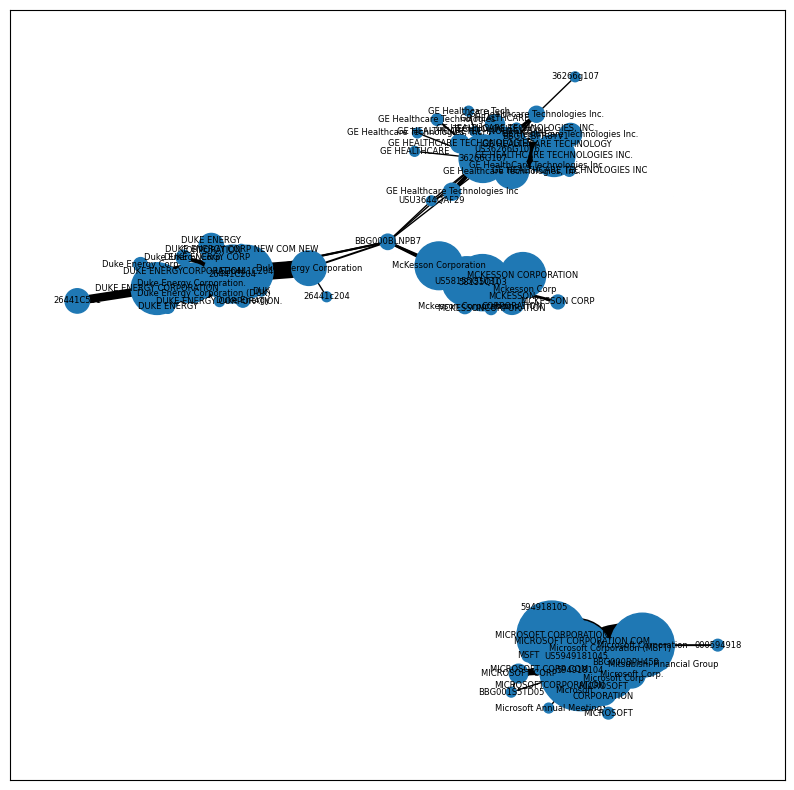

max_betweenness=0.15217391304347827
threshold=0.06
Iteration: 1


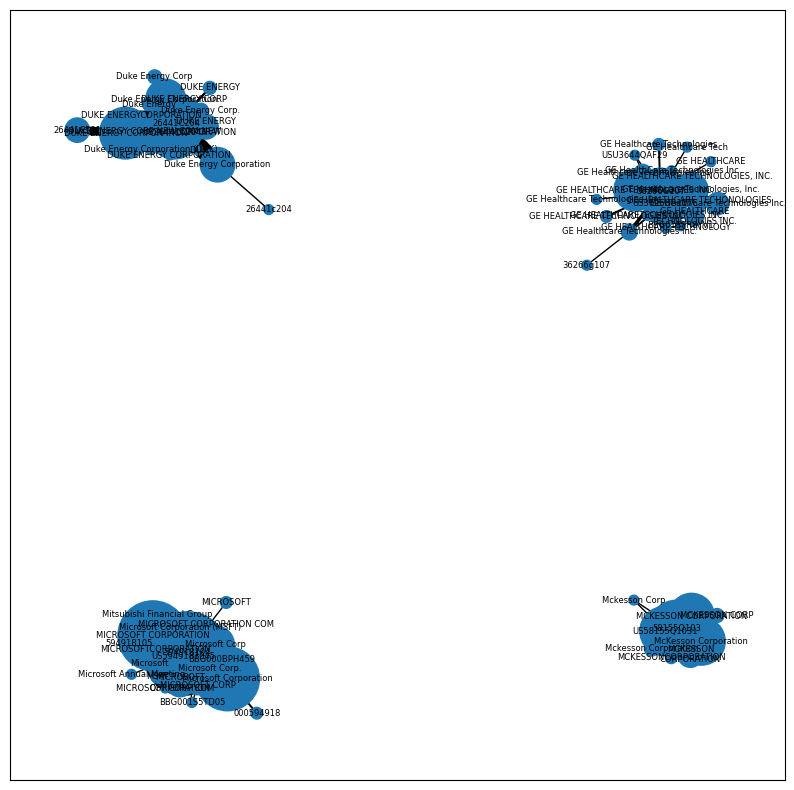

max_betweenness=0.03410059676044331
threshold=0.06


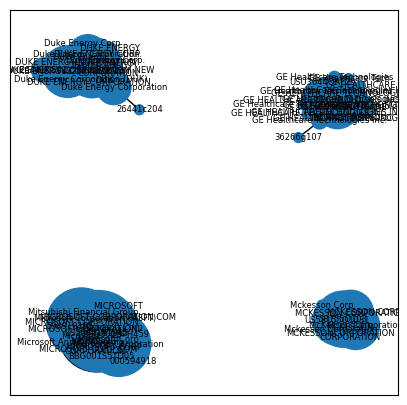

In [14]:
split_msft = split_subgraph_where_necessary(msft_subgraph.copy(), verbose=True)
draw_graph(split_msft, 5)

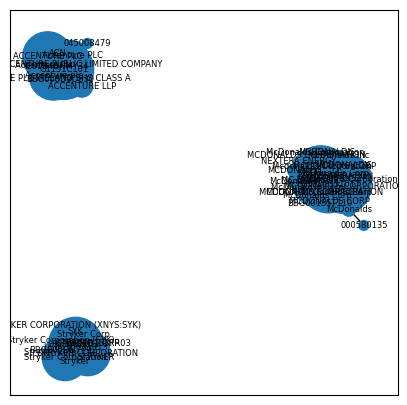

In [67]:
split_mcds = split_subgraph_where_necessary(mcds_subgraph.copy(), verbose=True)
draw_graph(split_mcds, 5)

issuer_name,count
str,u32
"""MICROSOFT CORPORATION""",2555
"""Microsoft Corporation""",1795
"""AMAZON.COM, INC.""",1656
"""The Walt Disney Company""",1489
"""THE WALT DISNEY COMPANY""",1408
"""CISCO SYSTEMS, INC.""",1405
"""JPMORGAN CHASE & CO.""",1324
"""ORACLE CORPORATION""",1287
"""THE PROCTER & GAMBLE COMPANY""",1186


In [49]:
_cut_points = tuple(nx.articulation_points(mcds_subgraph))
# {
#     edge: betweenness
#     for edge, betweenness in dict(betweens).items()
#     if any(node) in _cut_points
#     for node in edge
# }


74

In [47]:
tuple(nx.articulation_points(mcds_subgraph))

('580135101',
 'Accenture PLC',
 'G1151C101',
 'BBG000BLNWJ4',
 '863667101',
 'McDonalds',
 'US5801351017')

In [44]:
# for edge, betweenness in dict(betweens).items():
#     for node in edge:
#         print(node)
#         print(node in _cut_points)

Mcdonald's Corporation
580135101
Mcdonald's Corporation
US5801351017
Stryker Corp.
863667101
Stryker Corp.
US8636671013
McDonald's
580135101
McDonald's Corp
580135101
McDonald's Corp
US5801351017
McDonald's Corp
BBG000BNSZP1
045008479
Accenture PLC
G1151C101
ACCENTURE PLC
G1151C101
IE00B4BNMY34
G1151C101
Accenture plc
G1151C101
ACCENTURE LLP
G1151C101
Accenture PLC
G1151C101
Accenture Plc
G1151C101
ACCENTURE PLC IRELAND SHS CLASS A
G1151C101
BBG000D9D830
G1151C101
ACCENTURE PUBLIC LIMITED COMPANY
G1151C101
BBG000BLNWJ4
G1151C101
ACN
Accenture Plc
IE00B4BNMY34
BBG000DN7P92
Stryker Corporation
BBG000DN7P92
863667101
BBG000DN7P92
US8636671013
MCDONALDS CORP
580135101
MCDONALDS CORP
BBG001S5T110
BBG001S5T110
580135101
McDonalds Corp
580135101
McDonalds Corp
US5801351017
IE00B4BNMY34
ACCENTURE PLC
IE00B4BNMY34
Accenture plc
IE00B4BNMY34
Accenture PLC
IE00B4BNMY34
ACCENTURE PLC IRELAND SHS CLASS A
IE00B4BNMY34
BBG000D9D830
IE00B4BNMY34
BBG000BLNWJ4
IE00B4BNMY34
ACN
NEXTERA ENERGY
580135101
S

In [13]:
arts = tuple(nx.articulation_points(msft_subgraph))

In [14]:
arts[0]

'36266G107'

In [16]:
msft_subgraph2 = msft_subgraph.copy()

In [16]:
msft_subgraph2.remove_node(arts[0])

[296, 627, 319, 3, 9, 1, 3, 1, 2, 727, 562, 38, 39, 7, 1, 1, 1, 2, 1, 4, 2, 1, 1, 553, 3, 1, 6, 1, 1, 1, 1, 1776, 1351, 30, 2, 12, 237, 142, 1, 1, 1, 1, 1, 2, 1, 1756, 3182, 1, 13, 79, 1, 4, 58, 2, 4, 2, 2, 3, 2, 2, 2, 2544, 224, 13, 1, 4, 64, 77, 1, 60, 1, 2, 3, 1, 263, 261, 4, 4, 3, 842, 1, 151, 3, 4, 1, 1, 2, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 459, 1, 48, 44, 2, 2, 4, 1, 2, 1, 1]


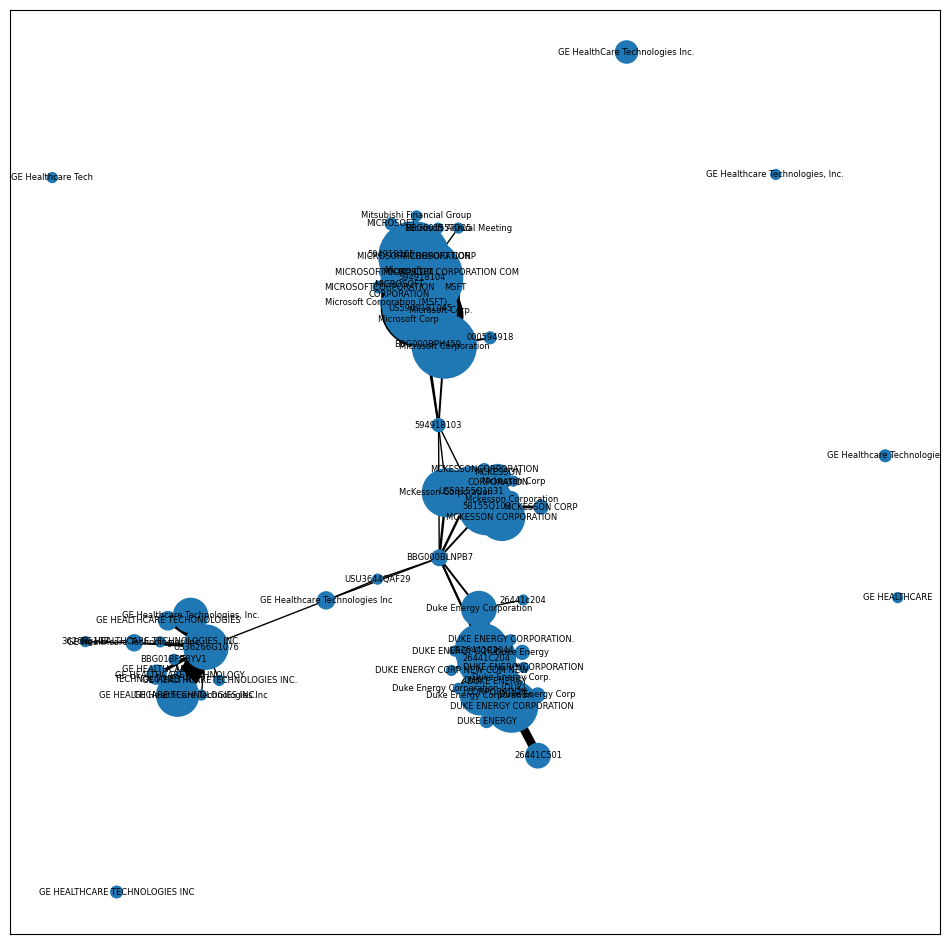

In [18]:
draw_graph(msft_subgraph2)

In [54]:
nx.is_biconnected(msft_subgraph)

False

In [10]:
set(msft_subgraph)

{'000594918',
 '26441C204',
 '26441C501',
 '26441c204',
 '36266G107',
 '36266g107',
 '58155Q103',
 '594918103',
 '594918104',
 '594918105',
 'BBG000BLNPB7',
 'BBG000BPH459',
 'BBG001S5TD05',
 'BBG01BFR8YV1',
 'DUK',
 'DUKE ENERGY',
 'DUKE ENERGY\nCORPORATION',
 'DUKE ENERGY CORP',
 'DUKE ENERGY CORP NEW COM NEW',
 'DUKE ENERGY CORPORATION',
 'DUKE ENERGY CORPORATION.',
 'DUKE ENERGYCORPORATION',
 'Duke Energy',
 'Duke Energy Corp',
 'Duke Energy Corp.',
 'Duke Energy Corporation',
 'Duke Energy Corporation (DUK)',
 'Duke Energy Corporation.',
 'GE HEALTHCARE',
 'GE HEALTHCARE\nTECHNOLOGIES INC.',
 'GE HEALTHCARE TECHNOLOGIES INC',
 'GE HEALTHCARE TECHNOLOGIES INC.',
 'GE HEALTHCARE TECHNOLOGIES, INC.',
 'GE HEALTHCARE TECHNOLOGY',
 'GE HEALTHCARE TECHONOLOGIES',
 'GE HEALTHCARETECHNOLOGIES INC.',
 'GE HealthCare Technologies Inc',
 'GE HealthCare Technologies Inc.',
 'GE Healthcare Tech',
 'GE Healthcare Technologies',
 'GE Healthcare Technologies Inc',
 'GE Healthcare Technologies Inc

In [18]:
print(list(msft_subgraph.edges.data()))

[('MICROSOFT', '594918104', {'count': 1, 'fields': {'issuer_name', 'cusip'}}), ('MCKESSON CORPORATION', '58155Q103', {'count': 459, 'fields': {'issuer_name', 'cusip'}}), ('MCKESSON CORPORATION', 'US58155Q1031', {'count': 319, 'fields': {'issuer_name', 'isin'}}), ('Microsoft', 'US5949181045', {'count': 1, 'fields': {'issuer_name', 'isin'}}), ('Microsoft', '594918104', {'count': 4, 'fields': {'issuer_name', 'cusip'}}), ('Mckesson Corporation', '58155Q103', {'count': 3, 'fields': {'issuer_name', 'cusip'}}), ('Mckesson Corporation', 'US58155Q1031', {'count': 3, 'fields': {'issuer_name', 'isin'}}), ('MCKESSON\nCORPORATION', '58155Q103', {'count': 44, 'fields': {'issuer_name', 'cusip'}}), ('MCKESSON\nCORPORATION', 'US58155Q1031', {'count': 9, 'fields': {'issuer_name', 'isin'}}), ('GE HEALTHCARE\nTECHNOLOGIES INC.', '36266G107', {'count': 14, 'fields': {'issuer_name', 'cusip'}}), ('GE HEALTHCARE\nTECHNOLOGIES INC.', 'US36266G1076', {'count': 6, 'fields': {'issuer_name', 'isin'}}), ('MICROSOFT

In [28]:
print(msft_subgraph)

Graph with 71 nodes and 129 edges


In [57]:
from typing import Callable


def extract_nodes_w_great_text_distance(
    G: nx.Graph, match_fnc: Callable = lambda node: node[1]["field"] == "issuer_name"
) -> tuple:
    relevant_nodes: list = [n for n in G.nodes.data() if match_fnc(n)]
    return relevant_nodes


t = extract_nodes_w_great_text_distance(msft_subgraph)
t

[('MICROSOFT', {'field': 'issuer_name', 'count': 2}),
 ('MCKESSON CORPORATION', {'field': 'issuer_name', 'count': 463}),
 ('Microsoft', {'field': 'issuer_name', 'count': 6}),
 ('Mckesson Corporation', {'field': 'issuer_name', 'count': 5}),
 ('MCKESSON\nCORPORATION', {'field': 'issuer_name', 'count': 44}),
 ('GE HEALTHCARE\nTECHNOLOGIES INC.', {'field': 'issuer_name', 'count': 14}),
 ('MICROSOFTCORPORATION', {'field': 'issuer_name', 'count': 2}),
 ('DUKE ENERGY CORPORATION', {'field': 'issuer_name', 'count': 768}),
 ('GE HEALTHCARE TECHNOLOGIES, INC.', {'field': 'issuer_name', 'count': 1}),
 ('Microsoft Corp.', {'field': 'issuer_name', 'count': 60}),
 ('DUKE ENERGY CORP', {'field': 'issuer_name', 'count': 1}),
 ('GE HEALTHCARE TECHONOLOGIES', {'field': 'issuer_name', 'count': 12}),
 ('Duke Energy Corp.', {'field': 'issuer_name', 'count': 5}),
 ('Microsoft Corporation', {'field': 'issuer_name', 'count': 1795}),
 ('DUKE ENERGYCORPORATION', {'field': 'issuer_name', 'count': 1}),
 ('McKesso

In [59]:
[x[0] for x in t]

['MICROSOFT',
 'MCKESSON CORPORATION',
 'Microsoft',
 'Mckesson Corporation',
 'MCKESSON\nCORPORATION',
 'GE HEALTHCARE\nTECHNOLOGIES INC.',
 'MICROSOFTCORPORATION',
 'DUKE ENERGY CORPORATION',
 'GE HEALTHCARE TECHNOLOGIES, INC.',
 'Microsoft Corp.',
 'DUKE ENERGY CORP',
 'GE HEALTHCARE TECHONOLOGIES',
 'Duke Energy Corp.',
 'Microsoft Corporation',
 'DUKE ENERGYCORPORATION',
 'McKesson Corporation',
 'MCKESSON CORP',
 'MSFT',
 'GE Healthcare Technologies, Inc. ',
 'Microsoft Corp',
 'DUKE ENERGY',
 'MICROSOFT\nCORPORATION',
 'GE HEALTHCARE TECHNOLOGIES INC',
 'GE HEALTHCARE TECHNOLOGIES INC.',
 'GE Healthcare Technologies',
 'Duke Energy Corporation (DUK)',
 'GE HEALTHCARE',
 'MICROSOFT CORPORATION',
 'DUKE ENERGY CORP NEW COM NEW',
 'GE Healthcare Technologies Inc',
 'Microsoft Corporation (MSFT)',
 'GE HEALTHCARETECHNOLOGIES INC.',
 'Mitsubishi Financial Group',
 'Duke Energy Corporation',
 'GE Healthcare Technologies, Inc.',
 'MICROSOFT CORP',
 'DUK',
 'GE HealthCare Technologies I

In [98]:
edge_peek = (
    pl.DataFrame(list(msft_subgraph.edges.data()), strict=False)
    .transpose()
    .rename(
        {
            "column_0": "value_0",
            "column_1": "value_1",
            "column_2": "n_and_field_names",
        }
    )
    .with_columns(
        (
            pl.col("n_and_field_names")
            .str.split(",")
            .list[0]
            .str.replace_all("{", "", literal=True)
            .cast(pl.Int16)
            .alias("n")
        ),
        (
            pl.col("n_and_field_names")
            .str.split(",{")
            .list[1]
            .str.replace_all("}", "", literal=True)
            .str.replace_all("'", "")
            .str.split(", ")
            .alias("field_names")
        ),
    )
    .with_columns(
        pl.col("field_names").list[0].alias("field_0_name"),
        pl.col("field_names").list[1].alias("field_1_name"),
    )
    .sort("n", descending=True)
).drop(["n_and_field_names"])
display(edge_peek)

value_0,value_1,n,field_names,field_0_name,field_1_name
str,str,i16,list[str],str,str
"""594918104""","""US5949181045""",3182,"[""isin"", ""cusip""]","""isin""","""cusip"""
"""594918104""","""MICROSOFT CORPORATION""",2544,"[""issuer_name"", ""cusip""]","""issuer_name""","""cusip"""
"""Microsoft Corporation""","""594918104""",1776,"[""issuer_name"", ""cusip""]","""issuer_name""","""cusip"""
"""MICROSOFT CORPORATION""","""US5949181045""",1756,"[""issuer_name"", ""isin""]","""issuer_name""","""isin"""
"""Microsoft Corporation""","""US5949181045""",1351,"[""issuer_name"", ""isin""]","""issuer_name""","""isin"""
…,…,…,…,…,…
"""MICROSOFT CORP COM""","""US5949181045""",1,"[""issuer_name"", ""isin""]","""issuer_name""","""isin"""
"""594918103""","""US58155Q1031""",1,"[""isin"", ""cusip""]","""isin""","""cusip"""
"""US58155Q1031""","""Mckesson Corp""",1,"[""issuer_name"", ""isin""]","""issuer_name""","""isin"""


In [109]:
import polars.functions as F

In [110]:
F.concat_list

AttributeError: 'function' object has no attribute '_pyexpr'

In [117]:
edge_peek.head(1)

value_0,value_1,n,field_names,field_0_name,field_1_name
str,str,i16,list[str],str,str
"""594918104""","""US5949181045""",3182,"[""isin"", ""cusip""]","""isin""","""cusip"""


In [139]:
edge_peek.drop("field_names").write_csv("edge_peek.csv")

In [132]:
edge_peek.unpivot(
    on=["field_0_name", "field_1_name"], index=["value_0", "value_1", "n"]
).pivot(
    on="value",
    values=["value_0", "value_1"],
    aggregate_function=F.element().unique(),
).with_columns(
    pl.coalesce(pl.col(f"value_0_{field}")).alias(field)
    for field in ["issuer_name", "figi", "cusip", "isin"]
    # pl.when(pl.col(f"value_0{field}").is_null()).then(pl.col(f"value_0{field}"))
    # for field in ["issuer_name", "figi", "cusip", "isin"]
)

n,variable,value_0_isin,value_0_issuer_name,value_0_figi,value_0_cusip,value_1_isin,value_1_issuer_name,value_1_figi,value_1_cusip,issuer_name,figi,cusip,isin
i16,str,list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str]
3182,"""field_0_name""","[""594918104""]",null,null,null,"[""US5949181045""]",null,null,null,null,null,null,"[""594918104""]"
2544,"""field_0_name""",null,"[""594918104""]",null,null,null,"[""MICROSOFT CORPORATION""]",null,null,"[""594918104""]",null,null,null
1776,"""field_0_name""",null,"[""Microsoft Corporation""]",null,null,null,"[""594918104""]",null,null,"[""Microsoft Corporation""]",null,null,null
1756,"""field_0_name""",null,"[""MICROSOFT CORPORATION""]",null,null,null,"[""US5949181045""]",null,null,"[""MICROSOFT CORPORATION""]",null,null,null
1351,"""field_0_name""",null,"[""Microsoft Corporation""]",null,null,null,"[""US5949181045""]",null,null,"[""Microsoft Corporation""]",null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…
6,"""field_1_name""","[""GE HEALTHCARE TECHNOLOGIES INC.""]",null,null,"[""36266G107""]","[""US36266G1076""]",null,null,"[""GE Healthcare Technologies Inc.""]",null,null,"[""36266G107""]","[""GE HEALTHCARE TECHNOLOGIES INC.""]"
4,"""field_1_name""","[""Microsoft Corp"", ""MICROSOFT CORP"", ""Duke Energy Corp.""]",null,null,"[""58155Q103"", ""Microsoft"", … ""26441C204""]","[""US26441C2044"", ""US5949181045""]",null,null,"[""26441C204"", ""Duke Energy"", … ""Duke Energy Corp""]",null,null,"[""58155Q103"", ""Microsoft"", … ""26441C204""]","[""Microsoft Corp"", ""MICROSOFT CORP"", ""Duke Energy Corp.""]"
3,"""field_1_name""","[""Duke Energy Corporation"", ""Mckesson Corporation"", ""MSFT""]",null,"[""BBG000BLNPB7"", ""McKesson Corporation""]","[""DUKE ENERGY"", ""MSFT"", ""Mckesson Corporation""]","[""US58155Q1031"", ""US5949181045"", ""US26441C2044""]",null,"[""US58155Q1031"", ""BBG000BLNPB7""]","[""594918104"", ""26441C204"", ""58155Q103""]",null,"[""BBG000BLNPB7"", ""McKesson Corporation""]","[""DUKE ENERGY"", ""MSFT"", ""Mckesson Corporation""]","[""Duke Energy Corporation"", ""Mckesson Corporation"", ""MSFT""]"


In [116]:
edge_peek.pivot(
    on=["field_0_name", "field_1_name"],
    values=["value_0", "value_1"],
    aggregate_function=F.element().unique(),
)

n,field_names,"value_0_{""isin"",""cusip""}","value_0_{""issuer_name"",""cusip""}","value_0_{""issuer_name"",""isin""}","value_0_{""isin"",""figi""}","value_0_{""figi"",""cusip""}","value_0_{""issuer_name"",""figi""}","value_1_{""isin"",""cusip""}","value_1_{""issuer_name"",""cusip""}","value_1_{""issuer_name"",""isin""}","value_1_{""isin"",""figi""}","value_1_{""figi"",""cusip""}","value_1_{""issuer_name"",""figi""}"
i16,list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str],list[str]
3182,"[""isin"", ""cusip""]","[""594918104""]",null,null,null,null,null,"[""US5949181045""]",null,null,null,null,null
2544,"[""issuer_name"", ""cusip""]",null,"[""594918104""]",null,null,null,null,null,"[""MICROSOFT CORPORATION""]",null,null,null,null
1776,"[""issuer_name"", ""cusip""]",null,"[""Microsoft Corporation""]",null,null,null,null,null,"[""594918104""]",null,null,null,null
1756,"[""issuer_name"", ""isin""]",null,null,"[""MICROSOFT CORPORATION""]",null,null,null,null,null,"[""US5949181045""]",null,null,null
1351,"[""issuer_name"", ""isin""]",null,null,"[""Microsoft Corporation""]",null,null,null,null,null,"[""US5949181045""]",null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,"[""issuer_name"", ""isin""]",null,null,"[""Microsoft"", ""GE HEALTHCARETECHNOLOGIES INC."", … ""DUKE ENERGY CORPORATION.""]",null,null,null,null,null,"[""USU3644QAF29"", ""US26441C2044"", … ""Mckesson Corp""]",null,null,null
1,"[""issuer_name"", ""figi""]",null,null,null,null,null,"[""BBG001S5TD05"", ""BBG000BPH459"", … ""GE Healthcare Technologies Inc""]",null,null,null,null,null,"[""MICROSOFT CORP"", ""Microsoft Corp"", … ""BBG000BLNPB7""]"
1,"[""figi"", ""cusip""]",null,null,null,null,"[""BBG01BFR8YV1"", ""36266G107"", … ""BBG001S5TD05""]",null,null,null,null,null,"[""BBG000BLNPB7"", ""594918103"", … ""36266G107""]",null


In [ ]:
sorted(
    list(msft_subgraph.edges.data()), key=lambda x: x[2]["count"], reverse=True
)  # [:5]

[('US5949181045', '594918104', {'count': 3182, 'fields': {'cusip', 'isin'}}),
 ('594918104',
  'MICROSOFT CORPORATION',
  {'count': 2544, 'fields': {'cusip', 'issuer_name'}}),
 ('Microsoft Corporation',
  '594918104',
  {'count': 1776, 'fields': {'cusip', 'issuer_name'}}),
 ('US5949181045',
  'MICROSOFT CORPORATION',
  {'count': 1756, 'fields': {'isin', 'issuer_name'}}),
 ('US5949181045',
  'Microsoft Corporation',
  {'count': 1351, 'fields': {'isin', 'issuer_name'}}),
 ('26441C204', 'US26441C2044', {'count': 842, 'fields': {'cusip', 'isin'}}),
 ('26441C204',
  'DUKE ENERGY CORPORATION',
  {'count': 727, 'fields': {'cusip', 'issuer_name'}}),
 ('US58155Q1031', '58155Q103', {'count': 627, 'fields': {'cusip', 'isin'}}),
 ('US26441C2044',
  'DUKE ENERGY CORPORATION',
  {'count': 562, 'fields': {'isin', 'issuer_name'}}),
 ('McKesson Corporation',
  '58155Q103',
  {'count': 553, 'fields': {'cusip', 'issuer_name'}}),
 ('MCKESSON CORPORATION',
  '58155Q103',
  {'count': 459, 'fields': {'cusip'

In [9]:

conn_counts: tuple[int, ...] = tuple(
    edge[2]["count"] for edge in msft_subgraph.edges.data()
)
cutoff: int = int(np.percentile(conn_counts, 25))
cutoff

1

In [10]:
import plotly.express as px

px.histogram(conn_counts, nbins=500)

In [37]:
from pprint import pprint
from typing import Callable, Iterable

import networkx as nx
import numpy as np

ConnectedSubgraphPreProcessor = Callable[[Iterable[nx.Graph]], Iterable[nx.Graph]]

# def split_edges_w_high_text_distance(G: nx.Graph) -> Iterable[nx.Graph]:
#     ...


def prune_bottom_pct_by_count(G: nx.Graph, percentile: int = 25) -> Iterable[nx.Graph]:
    """Remove the bottom *x* pct of connections, by popularity

    Args:
        G (nx.Graph): _description_
        percentile (int)

    Returns:
        Iterable[nx.Graph]: _description_

    NOTE: `percentile` is exclusive: if the 10th percentile `count` is 5, then all
    edges with count == 5 will also be removed.
    """
    if percentile < 1:
        raise ValueError(f"{percentile=} should be [0, 100]")
    conn_counts: tuple[int, ...] = tuple(edge[2]["count"] for edge in G.edges.data())
    cutoff: int = int(np.percentile(conn_counts, percentile))
    offending_edges: list[tuple] = [
        edge[:2] for edge in G.edges.data() if edge[2]["count"] <= cutoff
    ]
    # return offending_edges
    pprint(offending_edges)
    G.remove_edges_from(offending_edges)
    return G
    # for edge in G.edges.data():
    #     if edge[2]["count"] <= cutoff:
    #         G.remove_edges_from()

In [38]:
gg = prune_bottom_pct_by_count(msft_subgraph)

[('26441C501', 'DUKE ENERGY CORPORATION'),
 ('GE HealthCare Technologies Inc.', '36266G107'),
 ('MICROSOFT CORP', '594918104'),
 ('DUKE ENERGY\nCORPORATION', '26441C204'),
 ('36266G107', 'GE HEALTHCARE\nTECHNOLOGIES INC.'),
 ('36266G107', 'GE HEALTHCARE TECHONOLOGIES'),
 ('GE HEALTHCARE TECHONOLOGIES', 'US36266G1076'),
 ('MCKESSON\nCORPORATION', '58155Q103'),
 ('BBG000BPH459', 'Microsoft Corporation'),
 ('MICROSOFT\nCORPORATION', 'US5949181045')]


In [20]:
print(msft_subgraph)

Graph with 71 nodes and 59 edges


In [34]:
print(gg)

Graph with 71 nodes and 43 edges


In [43]:
nx.pagerank(msft_subgraph)

AttributeError: module 'networkx' has no attribute 'pagerank_numpy'

In [44]:
for edge in msft_subgraph.edges.data():
    print(edge)

('Duke Energy Corporation', '26441C204', {'count': 151, 'fields': {'cusip', 'issuer_name'}})
('McKesson Corporation', '58155Q103', {'count': 553, 'fields': {'cusip', 'issuer_name'}})
('McKesson Corporation', 'US58155Q1031', {'count': 296, 'fields': {'isin', 'issuer_name'}})
('MICROSOFT CORPORATION', '594918104', {'count': 2544, 'fields': {'cusip', 'issuer_name'}})
('MICROSOFT CORPORATION', 'US5949181045', {'count': 1756, 'fields': {'isin', 'issuer_name'}})
('36266G107', 'GE HEALTHCARE TECHNOLOGIES INC.', {'count': 326, 'fields': {'cusip', 'issuer_name'}})
('36266G107', 'US36266G1076', {'count': 402, 'fields': {'cusip', 'isin'}})
('36266G107', 'GE Healthcare Technologies, Inc.', {'count': 145, 'fields': {'cusip', 'issuer_name'}})
('GE HEALTHCARE TECHNOLOGIES INC.', 'US36266G1076', {'count': 237, 'fields': {'isin', 'issuer_name'}})
('DUKE ENERGY CORPORATION', '26441C204', {'count': 727, 'fields': {'cusip', 'issuer_name'}})
('DUKE ENERGY CORPORATION', 'US26441C2044', {'count': 562, 'field

In [12]:
sorted(
    list(msft_subgraph.edges.data()), key=lambda x: x[2]["count"], reverse=True
)  # [:5]

[('US5949181045', '594918104', {'count': 3182, 'fields': {'cusip', 'isin'}}),
 ('594918104',
  'MICROSOFT CORPORATION',
  {'count': 2544, 'fields': {'cusip', 'issuer_name'}}),
 ('Microsoft Corporation',
  '594918104',
  {'count': 1776, 'fields': {'cusip', 'issuer_name'}}),
 ('US5949181045',
  'MICROSOFT CORPORATION',
  {'count': 1756, 'fields': {'isin', 'issuer_name'}}),
 ('US5949181045',
  'Microsoft Corporation',
  {'count': 1351, 'fields': {'isin', 'issuer_name'}}),
 ('26441C204', 'US26441C2044', {'count': 842, 'fields': {'cusip', 'isin'}}),
 ('26441C204',
  'DUKE ENERGY CORPORATION',
  {'count': 727, 'fields': {'cusip', 'issuer_name'}}),
 ('US58155Q1031', '58155Q103', {'count': 627, 'fields': {'cusip', 'isin'}}),
 ('US26441C2044',
  'DUKE ENERGY CORPORATION',
  {'count': 562, 'fields': {'isin', 'issuer_name'}}),
 ('McKesson Corporation',
  '58155Q103',
  {'count': 553, 'fields': {'cusip', 'issuer_name'}}),
 ('MCKESSON CORPORATION',
  '58155Q103',
  {'count': 459, 'fields': {'cusip'

In [78]:
list(msft_subgraph.nodes.data())

[('594918104', {'field': 'cusip', 'count': 4698}),
 ('594918103', {'field': 'cusip', 'count': 3}),
 ('GE Healthcare Technologies, Inc. ', {'field': 'issuer_name', 'count': 1}),
 ('Microsoft Corp.', {'field': 'issuer_name', 'count': 60}),
 ('Microsoft Corp', {'field': 'issuer_name', 'count': 226}),
 ('MCKESSONCORPORATION', {'field': 'issuer_name', 'count': 2}),
 ('Microsoft Annual Meeting', {'field': 'issuer_name', 'count': 1}),
 ('Mitsubishi Financial Group', {'field': 'issuer_name', 'count': 1}),
 ('GE HEALTHCARE TECHONOLOGIES', {'field': 'issuer_name', 'count': 12}),
 ('DUKE ENERGY', {'field': 'issuer_name', 'count': 3}),
 ('Duke Energy Corporation', {'field': 'issuer_name', 'count': 152}),
 ('MICROSOFT CORPORATION', {'field': 'issuer_name', 'count': 2555}),
 ('594918105', {'field': 'cusip', 'count': 1}),
 ('MICROSOFT', {'field': 'issuer_name', 'count': 2}),
 ('GE Healthcare Technologies Inc', {'field': 'issuer_name', 'count': 9}),
 ('GE Healthcare Technologies Inc.', {'field': 'issu

In [69]:
msft_subgraph: list[nx.Graph] = [
    subg.copy()
    for subg in subgraphs
    if any(n[0][0] == "MICROSOFT CORPORATION" for n in subg.nodes.data())
]

In [72]:
for i, subg in enumerate(subgraphs):
    print(i)
    if i > 5:
        break
    for n in subg.nodes.data():
        print(n)
        print(n[0])
        print("!")

0
('Canadian Pacific Kansas City Limited', {'field': 'issuer_name', 'count': 132})
Canadian Pacific Kansas City Limited
!
('Canadian Pacific Kansas City', {'field': 'issuer_name', 'count': 1})
Canadian Pacific Kansas City
!
('CANADIAN PACIFIC\nKANSAS CITY LIMITED', {'field': 'issuer_name', 'count': 7})
CANADIAN PACIFIC
KANSAS CITY LIMITED
!
('CANADIAN PACIFIC KANSAS CITY', {'field': 'issuer_name', 'count': 2})
CANADIAN PACIFIC KANSAS CITY
!
('CANADIAN PACIFIC KANSAS\nCITY LIMITED', {'field': 'issuer_name', 'count': 3})
CANADIAN PACIFIC KANSAS
CITY LIMITED
!
('Canadian Pacific Kansas City Ltd', {'field': 'issuer_name', 'count': 2})
Canadian Pacific Kansas City Ltd
!
('CANADIAN PACIFIC KANSAS CITY LTD. COM', {'field': 'issuer_name', 'count': 1})
CANADIAN PACIFIC KANSAS CITY LTD. COM
!
('13645T100', {'field': 'cusip', 'count': 2})
13645T100
!
('CA13646K1084', {'field': 'isin', 'count': 368})
CA13646K1084
!
('CANADIAN PACIFIC KANSAS CITY LIMITED', {'field': 'issuer_name', 'count': 342})
CA